![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)


# Assignment 1: Small Scale Data (Classification)

In this assignment basic functionalities of [PyTorch](https://pytorch.org) will be explored for small datasets. The goal is to work on how to load images, pre-process the images and perform data augmentation. Finally, a deep neural network will be trained to perform image classification.

Note that all scripts should be self-contained and executed on *any* machine that has the required libraries installed. Moreover, you'll need to install PyTorch prior to starting this tutorial. This can be done using pip or conda. For more info. check [Install PyTorch](https://www.scaler.com/topics/pytorch/install-pytorch/) [Install PyTorch on Jupyter](https://timoast.github.io/blog/installing-pytorch/)

The solutions of the assignment can be delivered as Python Notebooks or .py files.



## Data loading 

In this task, the data will be loaded in two different way. At first, the `torchvision.datasets` subclasses will be used to load a dataset. Second, you will write your own dataset loader that performs the same activity. In the second case, the data and labels will be loaded from the hard-drive. Alternatively, they can be loaded from the RAM memory. Both solutions are acceptable. Only the train set is required. The datasets are [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) and [MNIST](http://yann.lecun.com/exdb/mnist/). Finally, the data samples and labels will be visualized. 

*Task Output*: It will be **two** different data loaders for MNIST and Fashion-MNIST. To demonstrate the data loading, the images and the corresponding labels should be vizualized. For the **visualization of the image and label**, you may use any library that you wish (e.g. [matplotlib](http://matplotlib.org/)).

*Important*: The scripts should be **self-contained**. This means that the custom dataloader should: 1. check whether the dataset is locally stored and 2. download it from the web if it not locally stored.

Tip: If it is not clear what is the train / test set when loading the data, you may check on the web-page of the dataset or on the related publication.

### a) Built-in Torch Dataloader

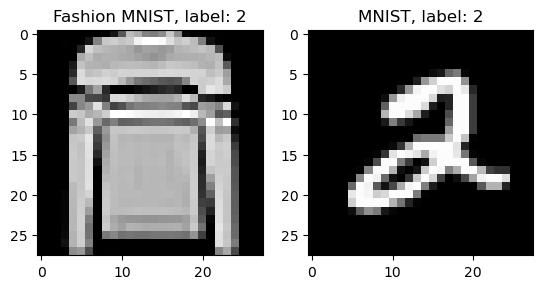

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

# To-Do: Implement Dataloader using PyTorch built-in function 

# Dataloader MNIST

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    #transform=ToTensor()
)


mnist_train_loader = DataLoader(training_data, batch_size=64, shuffle=True)

# Dataloader Fashion-MNIST

training_data_fashion = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    #transform=ToTensor()
)

mnist_fashion_train_loader = DataLoader(training_data_fashion, batch_size=64, shuffle=True)

# Visualize loaded images

img1, label1 = training_data_fashion[5]
img2, label2 = training_data[5]

# Plot the first image

plt.figure(1)
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title(f'Fashion MNIST, label: {label1}')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title(f'MNIST, label: {label2}')
plt.show()

### b) Customized Dataset

In this part you're asked to implement your own CustomDataset class instead of using PyTorch built-in function. To this end, you'll have to implement a function which downloads the datasets, you may use this download link 'http://yann.lecun.com/exdb/mnist/'. Also, you can rely on this documentation to handle [Gzip](https://docs.python.org/3/library/gzip.html#:~:text=To%20open%20a%20compressed%20file,and%20produces%20the%20most%20compression.) file format i.e. unzip file. Additional information on CustomDataset class can be obtained here [PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [5]:
import os
import gzip
import shutil
import requests
from torch.utils.data import Dataset
import idx2numpy

class CustomMNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train
        self.data_path = os.path.join(root, 'train' if train else 'test')
        self.images_path = None
        self.labels_path = None

        # Create directories if they don't exist
        os.makedirs(self.data_path, exist_ok=True)

        # Download and process data if not already done
        self.downloadDataset()

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)

    def downloadDataset(self):
        # URLs for the MNIST dataset files
        base_url = 'https://ossci-datasets.s3.amazonaws.com/mnist/'
        file_names = {
            'train': ('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz'),
            'test': ('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')
        }

        # Select which set to download
        files_to_download = file_names['train'] if self.train else file_names['test']

        # Download and extract files
        for file_name in files_to_download:
            url = f"{base_url}{file_name}"
            local_path = os.path.join(self.data_path, file_name)

            # Download file
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(local_path, 'wb') as f:
                    f.write(response.raw.read())

            # Extract file
            with gzip.open(local_path, 'rb') as f:
                #output_path = local_path.replace('.gz', '')
                if "images" in file_name:
                    #self.images_path = output_path
                    self.images = idx2numpy.convert_from_file(f)
                elif "labels" in file_name:
                    #self.labels_path = output_path
                    self.labels = idx2numpy.convert_from_file(f)       
            os.remove(local_path)  # Clean up the .gz file

        # Processing and saving tensors could be added here, using torchvision or custom routines to convert files to tensors

# Usage
# dataset = CustomMNIST(root='path_to_save_data', train=True, transform=transforms.ToTensor())


In [6]:
!git clone https://github.com/ivanyu/idx2numpy.git
!python idx2numpy//setup.py install

fatal: destination path 'idx2numpy' already exists and is not an empty directory.
Traceback (most recent call last):
  File "C:\Users\Admin\Desktop\fau\second semester\ml lab\assigments\idx2numpy\setup.py", line 11, in <module>
    with open("README.md", "r") as fh:
         ^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'README.md'


## 2. Model training 

In this task, the MNIST and [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset will be employed for learning a classifier. The classifier will be a convolutional neural network. You are free to decide for the network architecture. However, it should include at least 2 `nn.Conv2d` operations and at least 1 `nn.Linear` operation. The activation should be ReLU. The loss function will be the cross-entropy. Training will take place based on the train set of the dataset, also you should use part of the train set as validation and save the model with the best validation score. The test set will be used only for evaluation. Finally, the custom data-loader which has been implemented earlier will be employed here. Since there is train and test set, the data loader might need adaptation.

Parameter learning: The computation of the gradients and the optimization will be based on Pytorch (`torch.optim`).

Task Output: The output will be two **figures**, where in the first figure the x - axis represents the epochs and the y-axis represents the error. The plot of the train and test set will be drawn. The second figure will show the accuracy per epoch for the train and test set. Finally, the optimization parameters (optimizer and hyper-parameters) will be reported too.

In [7]:
# Implement your network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# Architecture class

class CNN(nn.Module):
    
    def __init__(self):
        
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128,10)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Function for training and validation

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    
    best_val_accuracy = 0.0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_train = 0
        correct_train = 0
        
        for images, labels in train_loader:
            images = np.copy(images)  # Make a copy to ensure it is writable
            images = torch.from_numpy(images)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0) #item extract float from tensor, then we multiply with batch size
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss / total_train)
        train_accuracies.append(train_accuracy)
            
        model.eval() 
        total_val = 0
        correct_val = 0
        val_loss = 0
        
        with torch.no_grad():
            
            for images, labels in val_loader:
                images = np.copy(images)  # Make a copy to ensure it is writable
                images = torch.from_numpy(images)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                total_val += labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
        val_accuracy =  correct_val / total_val
        val_losses.append(val_loss / total_val)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss / total_train:.4f}, Val Loss: {val_loss / total_val:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
         # Check if the current validation accuracy is the best we've seen so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy  # Update the best known accuracy
            torch.save(model.state_dict(), 'best_model.pth')  # Save the model
            print("Saved new best model")
            
    return train_losses, val_losses, train_accuracies, val_accuracies


# Show figures

from torch.utils.data import random_split

# Create an instance of your custom dataset

dataset = CustomMNIST(root="C:\\Users\\Admin\\Desktop\\fau\\second semester\\ml lab\\assigments\\data\\MNIST\\raw", train=True, transform=transforms.ToTensor())

train_size = int(0.8 * len(dataset))  # 80% of the dataset for training
val_size = len(dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader to handle batching

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, train_loader, val_loader, optimizer, criterion, 10)


C:\Users\Admin\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Epoch 1: Train Loss: 0.3548, Val Loss: 0.1508, Train Accuracy: 0.8997, Val Accuracy: 0.9558
Saved new best model
Epoch 2: Train Loss: 0.1026, Val Loss: 0.0911, Train Accuracy: 0.9696, Val Accuracy: 0.9738
Saved new best model
Epoch 3: Train Loss: 0.0681, Val Loss: 0.0721, Train Accuracy: 0.9795, Val Accuracy: 0.9795
Saved new best model
Epoch 4: Train Loss: 0.0522, Val Loss: 0.0651, Train Accuracy: 0.9839, Val Accuracy: 0.9809
Saved new best model
Epoch 5: Train Loss: 0.0431, Val Loss: 0.0529, Train Accuracy: 0.9870, Val Accuracy: 0.9844
Saved new best model
Epoch 6: Train Loss: 0.0359, Val Loss: 0.0533, Train Accuracy: 0.9886, Val Accuracy: 0.9841
Epoch 7: Train Loss: 0.0299, Val Loss: 0.0564, Train Accuracy: 0.9906, Val Accuracy: 0.9842
Epoch 8: Train Loss: 0.0264, Val Loss: 0.0596, Train Accuracy: 0.9920, Val Accuracy: 0.9832
Epoch 9: Train Loss: 0.0218, Val Loss: 0.0456, Train Accuracy: 0.9932, Val Accuracy: 0.9867
Saved new best model
Epoch 10: Train Loss: 0.0192, Val Loss: 0.0510

<module 'matplotlib.pyplot' from 'C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

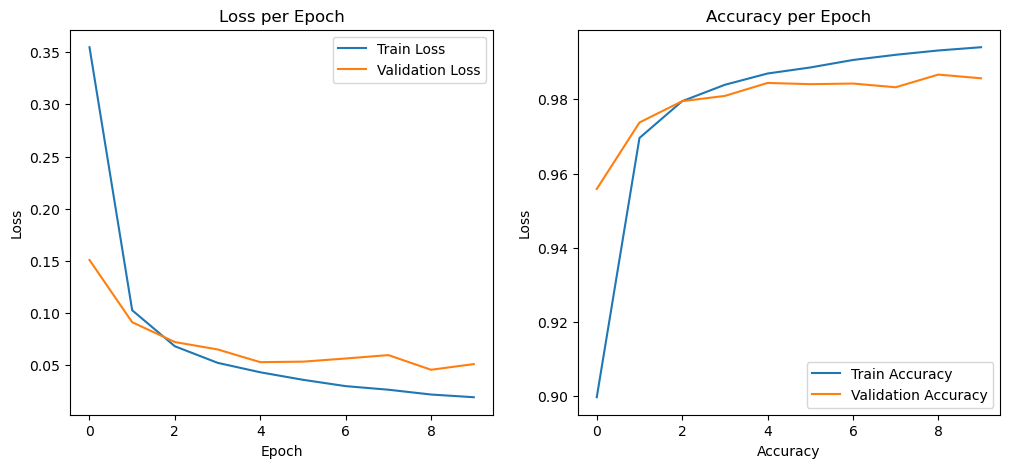

In [13]:
# Plotting the figures

# Figure one: Loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Figure two: Accuracy

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt

## 3. Data Augmentation


The datasets [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) and [MNIST](http://yann.lecun.com/exdb/mnist/) will be the testbed to investigate the impact of data augmentation. The source code from the last assignment can be used for data loading and model training. The network architecture can be the same from the last assignment as well. The data loading and augmentation can be done using the modules `torch.utils.data` and `torchvision`. Moreover, the dataset can be loaded from PyTorch class from each dataset.
 
*Task Output*: The required augmentation for this task is random affine with degree set to 20, translate (0.1,0.1) and scale (0.9,1.1). Moreover, color jitter should be applied on top with brightness set to 0.2 and also contrast to 0.2. At first, a model without augmentation should be trained. The performance on the test set will be the output of the task. Second, a model with data augmentation should be trained. The new performance on test will be now reported and compared to the accuracy without data augmentation.

*Important*: The scripts should be **self-contained**. The data augmentation should be dinamically implemented, i.e it is applied when the data from the mini-batch is loaded.

In [20]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [22]:
# Define transforms for augmentation

transform_augmentation = transforms.Compose([
    transforms.RandomAffine(degrees=20, translate = (0.1,0.1), scale = (0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Define basic transforms without augmentation

transform_basic = transforms.ToTensor()


In [25]:
# Function for evaluating the model after training on test data

def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No gradients needed
        for data, target in data_loader:
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy

In [28]:
from torch.utils.data import random_split

# Training models with basic transforms

# Load MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(mnist_train))  # 80% of the dataset for training
val_size = len(mnist_train) - train_size  # Remaining 20% for validation

mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

# Load Fashion MNIST dataset
fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_basic)
fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_basic)

train_size = int(0.8*len(fashion_mnist_train))
val_size = len(fashion_mnist_train) - train_size
fashion_mnist_train, fashion_mnist_val = random_split(fashion_mnist_train, [train_size, val_size])

# DataLoader for MNIST
mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_val_loader = DataLoader(mnist_val, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# DataLoader for Fashion MNIST
fashion_mnist_train_loader = DataLoader(fashion_mnist_train, batch_size=64, shuffle=True)
fashion_mnist_val_loader = DataLoader(fashion_mnist_val, batch_size=64, shuffle=True)
fashion_mnist_test_loader = DataLoader(fashion_mnist_test, batch_size=64, shuffle=False)

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, mnist_train_loader, mnist_val_loader, optimizer, criterion, 10)



Epoch 1: Train Loss: 1.1693, Val Loss: 0.6495, Train Accuracy: 0.6298, Val Accuracy: 0.7996
Saved new best model
Epoch 2: Train Loss: 0.4571, Val Loss: 0.3370, Train Accuracy: 0.8664, Val Accuracy: 0.9043
Saved new best model
Epoch 3: Train Loss: 0.2974, Val Loss: 0.2737, Train Accuracy: 0.9135, Val Accuracy: 0.9175
Saved new best model
Epoch 4: Train Loss: 0.2408, Val Loss: 0.2294, Train Accuracy: 0.9293, Val Accuracy: 0.9311
Saved new best model
Epoch 5: Train Loss: 0.2093, Val Loss: 0.1933, Train Accuracy: 0.9367, Val Accuracy: 0.9430
Saved new best model
Epoch 6: Train Loss: 0.1889, Val Loss: 0.1861, Train Accuracy: 0.9423, Val Accuracy: 0.9424
Epoch 7: Train Loss: 0.1758, Val Loss: 0.1622, Train Accuracy: 0.9475, Val Accuracy: 0.9524
Saved new best model
Epoch 8: Train Loss: 0.1598, Val Loss: 0.1653, Train Accuracy: 0.9504, Val Accuracy: 0.9499
Epoch 9: Train Loss: 0.1502, Val Loss: 0.1537, Train Accuracy: 0.9541, Val Accuracy: 0.9530
Saved new best model
Epoch 10: Train Loss: 0.1

In [29]:
def plot_metrics(test_loss, test_accuracy):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Test Loss')
    plt.bar('Test Loss', test_loss)
    plt.xlabel('Metric')
    plt.ylabel('Value')

    plt.subplot(1, 2, 2)
    plt.title('Test Accuracy')
    plt.bar('Test Accuracy', test_accuracy)
    plt.xlabel('Metric')
    plt.ylabel('Percentage')
    
    plt.tight_layout()
    plt.show()

Test set: Average loss: 0.0019, Accuracy: 96.25%
Test Loss: 0.0019
Accuracy: 96.25%


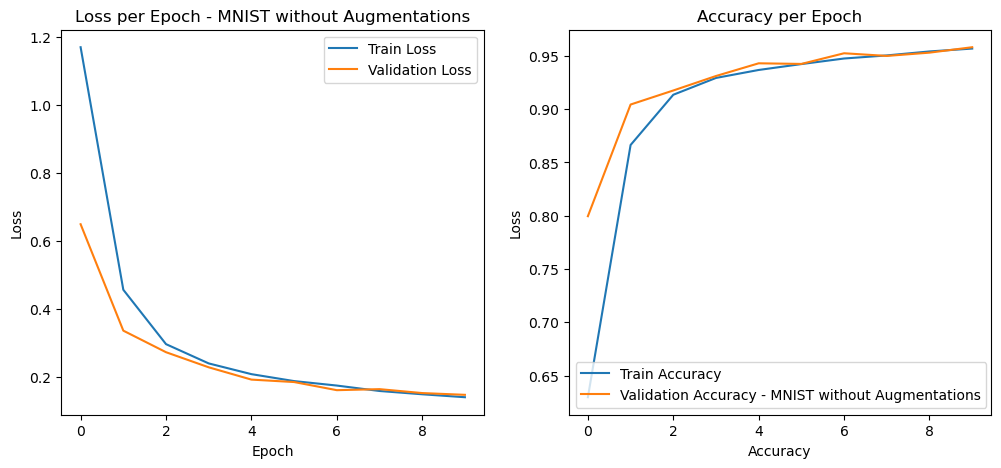

In [31]:
# Figure one: Loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch - MNIST without Augmentations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Figure two: Accuracy

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy - MNIST without Augmentations')
plt.title('Accuracy per Epoch')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt

# Evaluate the model on the test dataset
test_loss, test_accuracy = evaluate(model, mnist_test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy: {test_accuracy:.2f}%')

Epoch 1: Train Loss: 0.7936, Val Loss: 0.5290, Train Accuracy: 0.7269, Val Accuracy: 0.8047
Saved new best model
Epoch 2: Train Loss: 0.4907, Val Loss: 0.4368, Train Accuracy: 0.8242, Val Accuracy: 0.8409
Saved new best model
Epoch 3: Train Loss: 0.4262, Val Loss: 0.3999, Train Accuracy: 0.8483, Val Accuracy: 0.8525
Saved new best model
Epoch 4: Train Loss: 0.3935, Val Loss: 0.3730, Train Accuracy: 0.8609, Val Accuracy: 0.8664
Saved new best model
Epoch 5: Train Loss: 0.3690, Val Loss: 0.3745, Train Accuracy: 0.8697, Val Accuracy: 0.8641
Epoch 6: Train Loss: 0.3522, Val Loss: 0.3370, Train Accuracy: 0.8737, Val Accuracy: 0.8788
Saved new best model
Epoch 7: Train Loss: 0.3358, Val Loss: 0.3276, Train Accuracy: 0.8801, Val Accuracy: 0.8835
Saved new best model
Epoch 8: Train Loss: 0.3235, Val Loss: 0.3220, Train Accuracy: 0.8837, Val Accuracy: 0.8828
Epoch 9: Train Loss: 0.3120, Val Loss: 0.3098, Train Accuracy: 0.8886, Val Accuracy: 0.8882
Saved new best model
Epoch 10: Train Loss: 0.3

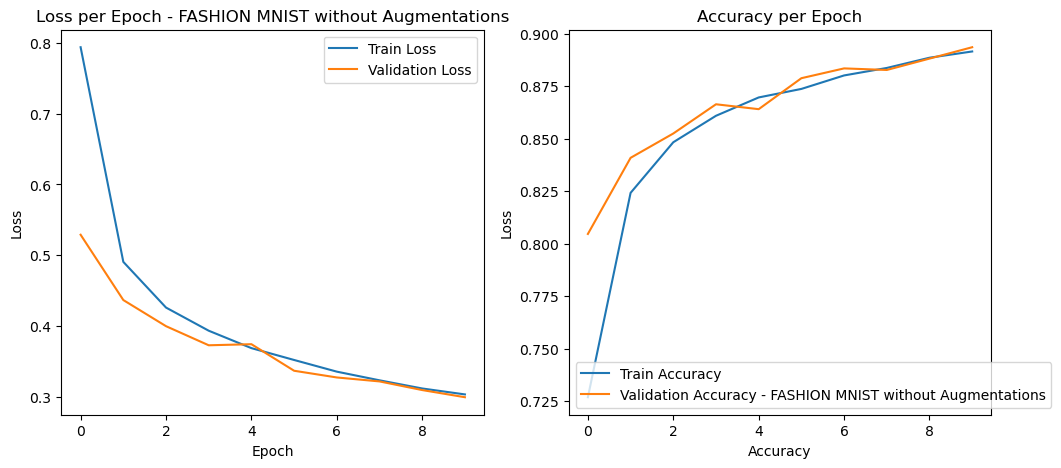

In [32]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, fashion_mnist_train_loader, fashion_mnist_val_loader, optimizer, criterion, 10)

# Figure one: Loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch - FASHION MNIST without Augmentations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Figure two: Accuracy

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy - FASHION MNIST without Augmentations')
plt.title('Accuracy per Epoch')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt

# Evaluate the model on the test dataset
test_loss, test_accuracy = evaluate(model, fashion_mnist_test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy: {test_accuracy:.2f}%')

In [38]:
# Training models with augmentations transforms

# Load MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_augmentation)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_basic)

train_size = int(0.8 * len(mnist_train))  # 80% of the dataset for training
val_size = len(mnist_train) - train_size  # Remaining 20% for validation

mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

# Load Fashion MNIST dataset
fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_augmentation)
fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_basic)

train_size = int(0.8*len(fashion_mnist_train))
val_size = len(fashion_mnist_train) - train_size
fashion_mnist_train, fashion_mnist_val = random_split(fashion_mnist_train, [train_size, val_size])

# DataLoader for MNIST
mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_val_loader = DataLoader(mnist_val, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# DataLoader for Fashion MNIST
fashion_mnist_train_loader = DataLoader(fashion_mnist_train, batch_size=64, shuffle=True)
fashion_mnist_val_loader = DataLoader(fashion_mnist_val, batch_size=64, shuffle=True)
fashion_mnist_test_loader = DataLoader(fashion_mnist_test, batch_size=64, shuffle=False)

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, mnist_train_loader, mnist_val_loader, optimizer, criterion, 10)



Epoch 1: Train Loss: 1.1493, Val Loss: 0.6420, Train Accuracy: 0.6405, Val Accuracy: 0.8061
Saved new best model
Epoch 2: Train Loss: 0.4677, Val Loss: 0.3815, Train Accuracy: 0.8611, Val Accuracy: 0.8881
Saved new best model
Epoch 3: Train Loss: 0.3182, Val Loss: 0.2946, Train Accuracy: 0.9051, Val Accuracy: 0.9094
Saved new best model
Epoch 4: Train Loss: 0.2572, Val Loss: 0.2477, Train Accuracy: 0.9233, Val Accuracy: 0.9276
Saved new best model
Epoch 5: Train Loss: 0.2199, Val Loss: 0.1988, Train Accuracy: 0.9332, Val Accuracy: 0.9406
Saved new best model
Epoch 6: Train Loss: 0.1941, Val Loss: 0.1828, Train Accuracy: 0.9422, Val Accuracy: 0.9448
Saved new best model
Epoch 7: Train Loss: 0.1755, Val Loss: 0.1688, Train Accuracy: 0.9474, Val Accuracy: 0.9503
Saved new best model
Epoch 8: Train Loss: 0.1621, Val Loss: 0.1557, Train Accuracy: 0.9512, Val Accuracy: 0.9507
Saved new best model
Epoch 9: Train Loss: 0.1481, Val Loss: 0.1395, Train Accuracy: 0.9560, Val Accuracy: 0.9578
Save

Test set: Average loss: 0.0007, Accuracy: 98.48%
Test Loss: 0.0007
Accuracy: 98.48%


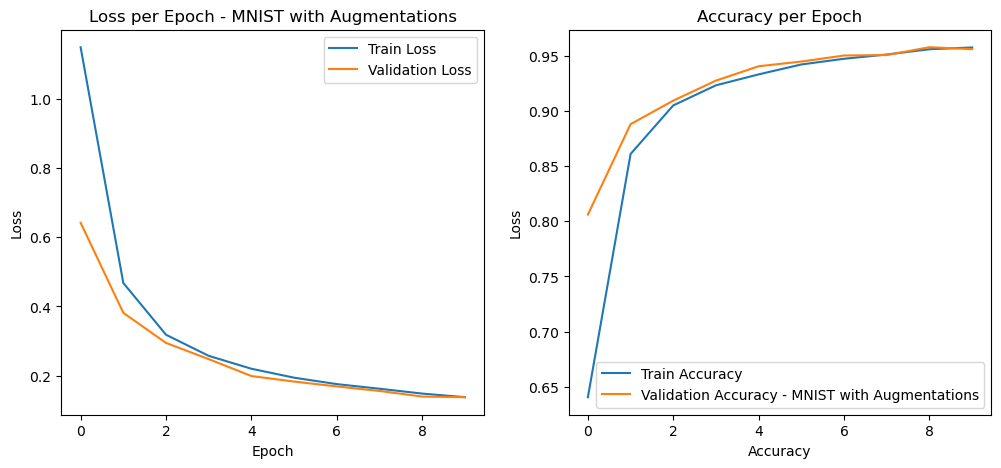

In [39]:
# Figure one: Loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch - MNIST with Augmentations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Figure two: Accuracy

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy - MNIST with Augmentations')
plt.title('Accuracy per Epoch')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt

# Evaluate the model on the test dataset
test_loss, test_accuracy = evaluate(model, mnist_test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy: {test_accuracy:.2f}%')


Epoch 1: Train Loss: 1.0784, Val Loss: 0.8008, Train Accuracy: 0.6220, Val Accuracy: 0.7007
Saved new best model
Epoch 2: Train Loss: 0.7632, Val Loss: 0.7247, Train Accuracy: 0.7150, Val Accuracy: 0.7242
Saved new best model
Epoch 3: Train Loss: 0.7155, Val Loss: 0.6989, Train Accuracy: 0.7306, Val Accuracy: 0.7290
Saved new best model
Epoch 4: Train Loss: 0.6778, Val Loss: 0.6398, Train Accuracy: 0.7463, Val Accuracy: 0.7582
Saved new best model
Epoch 5: Train Loss: 0.6455, Val Loss: 0.6430, Train Accuracy: 0.7562, Val Accuracy: 0.7561
Epoch 6: Train Loss: 0.6184, Val Loss: 0.6018, Train Accuracy: 0.7666, Val Accuracy: 0.7763
Saved new best model
Epoch 7: Train Loss: 0.5973, Val Loss: 0.5779, Train Accuracy: 0.7720, Val Accuracy: 0.7820
Saved new best model
Epoch 8: Train Loss: 0.5819, Val Loss: 0.5629, Train Accuracy: 0.7820, Val Accuracy: 0.7914
Saved new best model
Epoch 9: Train Loss: 0.5608, Val Loss: 0.5497, Train Accuracy: 0.7880, Val Accuracy: 0.7953
Saved new best model
Epoc

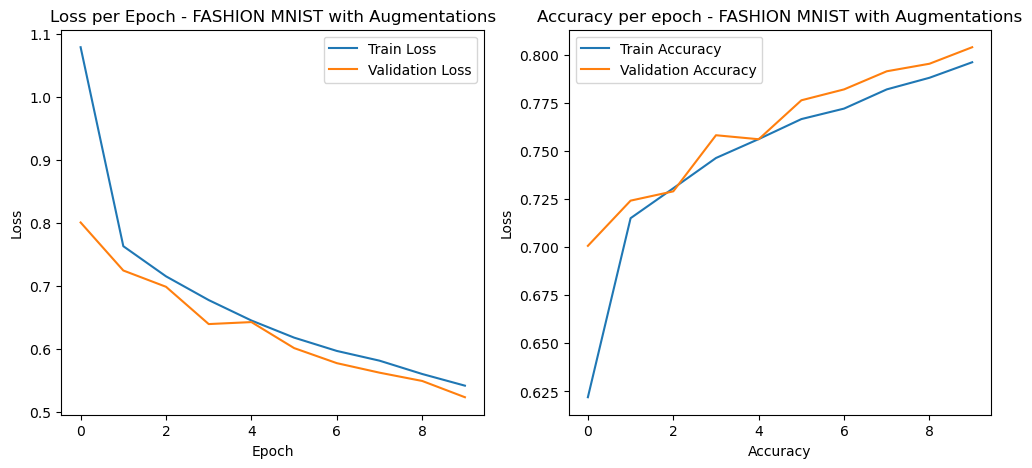

In [40]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, fashion_mnist_train_loader, fashion_mnist_val_loader, optimizer, criterion, 10)

# Figure one: Loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch - FASHION MNIST with Augmentations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Figure two: Accuracy

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per epoch - FASHION MNIST with Augmentations')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt

# Evaluate the model on the test dataset
test_loss, test_accuracy = evaluate(model, fashion_mnist_test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy: {test_accuracy:.2f}%')

# Results

## MNIST DATA SET
### 1. Results without augmentation

Accuracy: 96.25%
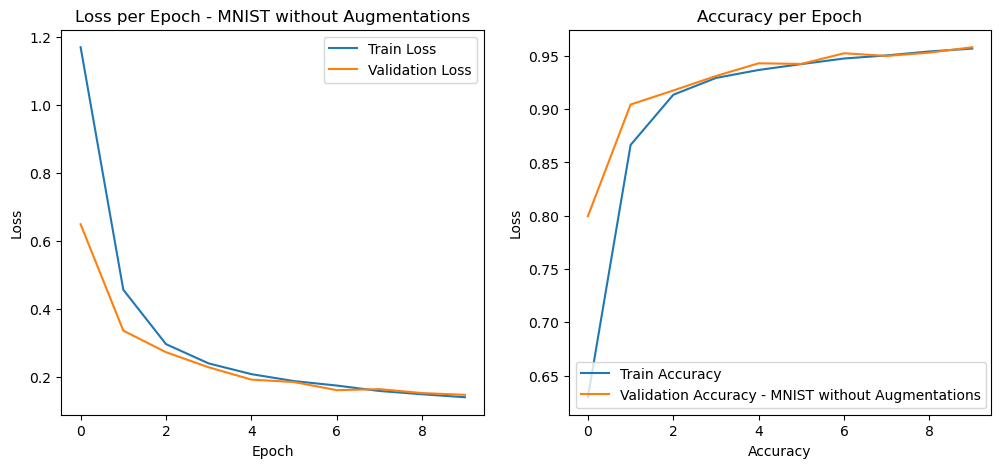

### 2. Results with augmentation

Accuracy: 98.48%

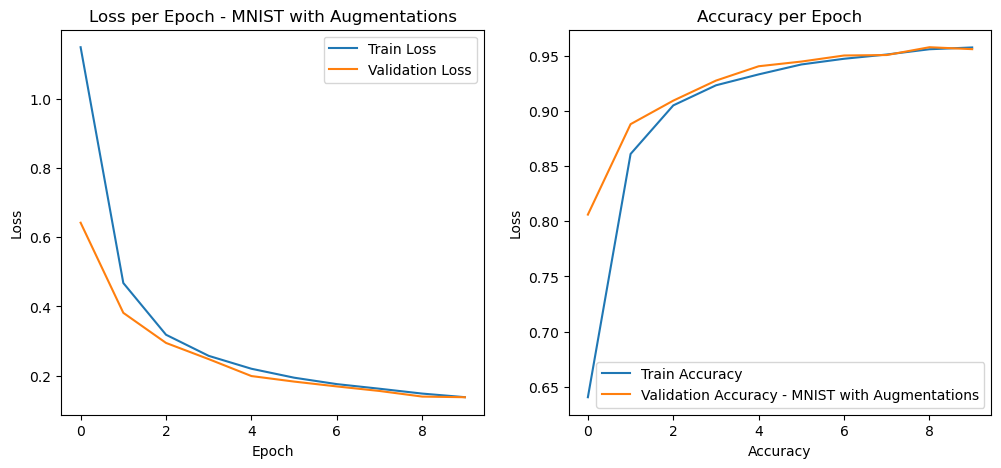

We can see the improvement in the test accuracy because of augmentation.


### 2. Results with augmentation

## FASHION MNIST DATA SET
### 1. Results without augmentation

Accuracy: 87.99%

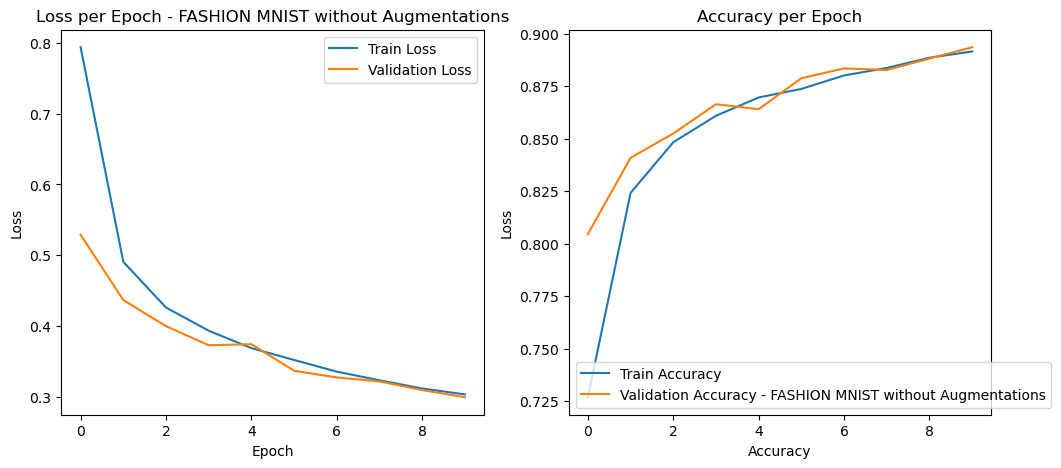

### 2. Results with augmentation

Accuracy: 82.46%

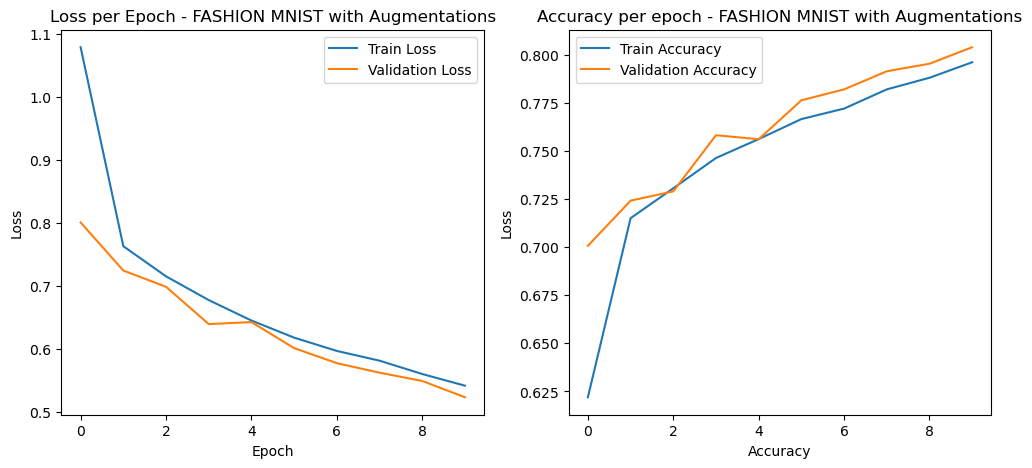

Results are worse with augmentation. Again, with longer training it should be able to achieve better results.